In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 定义多臂赌博机环境
class MultiArmedBandit:
    def __init__(self, k, means):
        """
        初始化多臂赌博机。
        :param k: 摇臂数量
        :param means: 每个摇臂的奖励均值
        """
        self.k = k
        self.means = means

    def pull(self, arm):
        """
        拉动指定的摇臂，返回奖励。
        :param arm: 摇臂索引
        :return: 奖励值
        """
        return np.random.binomial(1, self.means[arm])

# 定义UCB1算法
class UCB1:
    def __init__(self, k):
        """
        初始化UCB1算法。
        :param k: 摇臂数量
        """
        self.k = k
        self.counts = np.zeros(k)  # 每个摇臂被选择的次数
        self.values = np.zeros(k)  # 每个摇臂的平均奖励

    def select_arm(self):
        """
        选择摇臂。
        :return: 摇臂索引
        """
        # 如果还有摇臂未被选择过，优先选择
        if np.any(self.counts == 0):
            return np.argmin(self.counts)
        
        # 计算UCB1值
        total_counts = np.sum(self.counts)
        ucb_values = self.values + np.sqrt(2 * np.log(total_counts) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        """
        更新摇臂的统计信息。
        :param arm: 摇臂索引
        :param reward: 获得的奖励
        """
        self.counts[arm] += 1
        n = self.counts[arm]
        self.values[arm] = (self.values[arm] * (n - 1) + reward) / n

In [2]:
# 定义汤普森采样算法
class ThompsonSampling:
    def __init__(self, k):
        """
        初始化汤普森采样算法。
        :param k: 摇臂数量
        """
        self.k = k
        self.alpha = np.ones(k)  # Beta分布参数α（成功次数）
        self.beta = np.ones(k)   # Beta分布参数β（失败次数）

    def select_arm(self):
        """
        选择摇臂。
        :return: 摇臂索引
        """
        # 从每个摇臂的Beta分布中采样一个值
        sampled_values = np.random.beta(self.alpha, self.beta)
        return np.argmax(sampled_values)

    def update(self, arm, reward):
        """
        更新摇臂的统计信息。
        :param arm: 摇臂索引
        :param reward: 获得的奖励
        """
        if reward == 1:
            self.alpha[arm] += 1
        else:
            self.beta[arm] += 1

# 定义ε-贪心算法
class EpsilonGreedy:
    def __init__(self, k, epsilon):
        """
        初始化ε-贪心算法。
        :param k: 摇臂数量
        :param epsilon: 探索概率
        """
        self.k = k
        self.epsilon = epsilon
        self.counts = np.zeros(k)  # 每个摇臂被选择的次数
        self.values = np.zeros(k)  # 每个摇臂的平均奖励

    def select_arm(self):
        """
        选择摇臂。
        :return: 摇臂索引
        """
        if np.random.rand() < self.epsilon:
            # 探索：随机选择一个摇臂
            return np.random.randint(self.k)
        else:
            # 利用：选择当前平均奖励最高的摇臂
            return np.argmax(self.values)

    def update(self, arm, reward):
        """
        更新摇臂的统计信息。
        :param arm: 摇臂索引
        :param reward: 获得的奖励
        """
        self.counts[arm] += 1
        n = self.counts[arm]
        self.values[arm] = (self.values[arm] * (n - 1) + reward) / n


摇臂编号及其奖励均值：
摇臂 0: 奖励均值 0.3745401188473625
摇臂 1: 奖励均值 0.9507143064099162
摇臂 2: 奖励均值 0.7319939418114051
摇臂 3: 奖励均值 0.5986584841970366
摇臂 4: 奖励均值 0.15601864044243652
摇臂 5: 奖励均值 0.15599452033620265
摇臂 6: 奖励均值 0.05808361216819946
摇臂 7: 奖励均值 0.8661761457749352
摇臂 8: 奖励均值 0.6011150117432088
摇臂 9: 奖励均值 0.7080725777960455


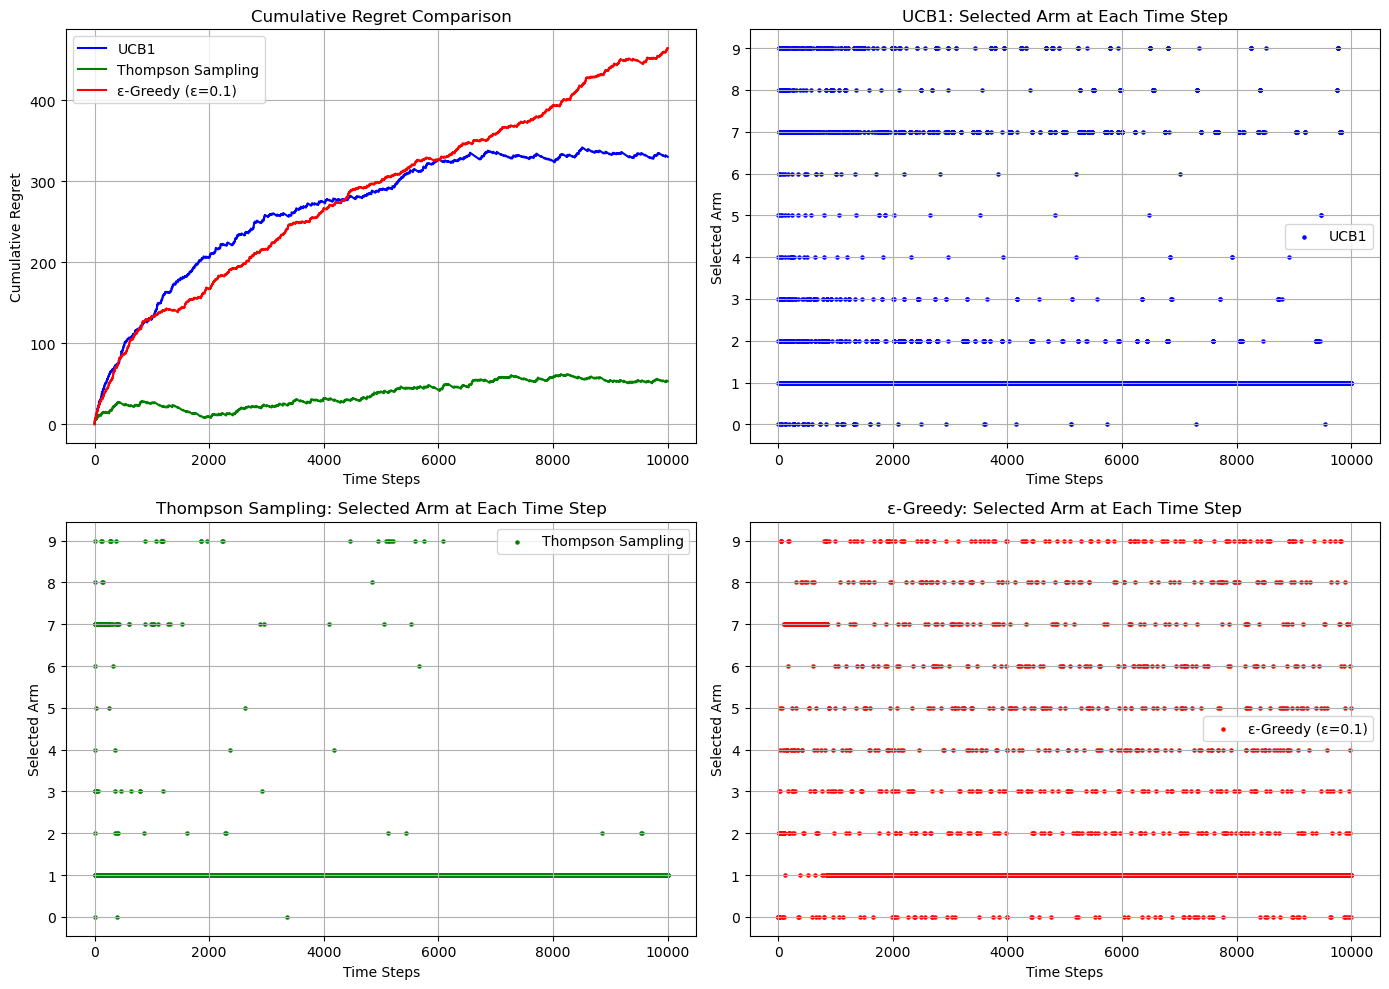

In [3]:
# 实验设置
np.random.seed(42)  # 设置随机种子
k = 10  # 摇臂数量
means = np.random.uniform(0, 1, k) # 每个摇臂的奖励均值，范围为[0, 1]
bandit = MultiArmedBandit(k, means)
ucb1 = UCB1(k)
best_arm = np.argmax(means)  # 最优摇臂
best_reward = means[best_arm]  # 最优摇臂的奖励均值

# 运行实验的函数
def run_experiment(bandit, algorithm, T):
    """
    运行实验并返回累积后悔值和选择的摇臂编号。
    :param bandit: 多臂赌博机环境
    :param algorithm: 算法（UCB1、ThompsonSampling、EpsilonGreedy）
    :param T: 总时间步数
    :return: 累积后悔值列表，选择的摇臂编号列表
    """
    regrets = []
    selected_arms = []
    cumulative_regret = 0

    for t in range(1, T + 1):
        arm = algorithm.select_arm()
        reward = bandit.pull(arm)
        algorithm.update(arm, reward)

        # 计算后悔值
        regret = best_reward - reward
        cumulative_regret += regret
        regrets.append(cumulative_regret)
        selected_arms.append(arm)

    return regrets, selected_arms

# 打印摇臂编号及其奖励均值
print("摇臂编号及其奖励均值：")
for i in range(k):
    print(f"摇臂 {i}: 奖励均值 {means[i]}")
epsilon = 0.1  # ε-贪心算法的探索概率
T = 10000  # 总时间步数
# 运行UCB1算法
ucb1_algorithm = UCB1(k)
ucb1_regrets, ucb1_selected_arms = run_experiment(bandit, ucb1_algorithm, T)

# 运行汤普森采样
ts_algorithm = ThompsonSampling(k)
ts_regrets, ts_selected_arms = run_experiment(bandit, ts_algorithm, T)

# 运行ε-贪心算法
eg_algorithm = EpsilonGreedy(k, epsilon)
eg_regrets, eg_selected_arms = run_experiment(bandit, eg_algorithm, T)

# 绘制结果
plt.figure(figsize=(14, 10))

# 子图1：累积后悔值对比
plt.subplot(2, 2, 1)
plt.plot(range(1, T + 1), ucb1_regrets, label="UCB1", color="blue")
plt.plot(range(1, T + 1), ts_regrets, label="Thompson Sampling", color="green")
plt.plot(range(1, T + 1), eg_regrets, label="ε-Greedy (ε=0.1)", color="red")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret Comparison")
plt.legend()
plt.grid(True)

# 子图2：UCB1选择的摇臂编号
plt.subplot(2, 2, 2)
plt.scatter(range(1, T + 1), ucb1_selected_arms, label="UCB1", color="blue", s=5)
plt.xlabel("Time Steps")
plt.ylabel("Selected Arm")
plt.yticks(np.arange(k))
plt.title("UCB1: Selected Arm at Each Time Step")
plt.legend()
plt.grid(True)

# 子图3：汤普森采样选择的摇臂编号
plt.subplot(2, 2, 3)
plt.scatter(range(1, T + 1), ts_selected_arms, label="Thompson Sampling", color="green", s=5)
plt.xlabel("Time Steps")
plt.ylabel("Selected Arm")
plt.yticks(np.arange(k))
plt.title("Thompson Sampling: Selected Arm at Each Time Step")
plt.legend()
plt.grid(True)

# 子图4：ε-贪心算法选择的摇臂编号
plt.subplot(2, 2, 4)
plt.scatter(range(1, T + 1), eg_selected_arms, label="ε-Greedy (ε=0.1)", color="red", s=5)
plt.xlabel("Time Steps")
plt.ylabel("Selected Arm")
plt.yticks(np.arange(k))
plt.title("ε-Greedy: Selected Arm at Each Time Step")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()